In [1]:
## cytassist visium analysis
import numpy as np
import scanpy as sc
import anndata
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scvi
import os

Global seed set to 0
/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/code')
import useful_functions as uf
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response')

In [3]:
def select_slide(adata, s, s_col='sample'):
        r""" This function selects the data for one slide from the spatial anndata object.

        :param adata: Anndata object with multiple spatial experiments
        :param s: name of selected experiment
        :param s_col: column in adata.obs listing experiment name for each location
        """

        slide = adata[adata.obs[s_col].isin([s]), :]
        s_keys = list(slide.uns['spatial'].keys())
        s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

        slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
        return slide

In [4]:
results_folder = '/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/cell2location'
run_name = f'{results_folder}/healthy_kidney_visium_cell2location_map' #### this is the output dir

In [5]:
adata_file = f"{run_name}/sp.h5ad"
adata = sc.read_h5ad(adata_file)

In [6]:
#read in some unlinking info
BW3_BW5 = pd.read_csv("./data/seq_data/visium/pathology_mixed_donor/BW3_BW5.csv", index_col = 0)
BW3_BW5.index = 'spaceranger210_count_47747_CZI_D_KIDsp13813009_GRCh38-2020-A' + "_" + np.array(BW3_BW5.index)
BW6_BW1 = pd.read_csv("./data/seq_data/visium/pathology_mixed_donor/BW6_BW1.csv", index_col = 0)
BW6_BW1.index = 'spaceranger210_count_47747_CZI_D_KIDsp13813010_GRCh38-2020-A' + "_" + np.array(BW6_BW1.index)
BW3_spots = np.array(BW3_BW5.index[BW3_BW5.donor == 'BW3'])
BW5_spots = np.array(BW3_BW5.index[BW3_BW5.donor == 'BW5'])
BW1_spots = np.array(BW6_BW1.index[BW6_BW1.donor == 'BW1'])
BW6_spots = np.array(BW6_BW1.index[BW6_BW1.donor == 'BW6'])
donors = np.array(adata.obs['donor'])
donors[adata.obs_names.isin(BW3_spots)] = 'BW3'
donors[adata.obs_names.isin(BW5_spots)] = 'BW5'
donors[adata.obs_names.isin(BW1_spots)] = 'BW1'
donors[adata.obs_names.isin(BW6_spots)] = 'BW6'
pd.Categorical(donors).value_counts()
adata.obs['donor'] = donors

In [7]:
adata.obs[adata.uns['mod']['factor_names']] = adata.obsm['q05_cell_abundance_w_sf']

In [8]:
pd.crosstab(adata.obs['sample'], adata.obs['donor'])

donor                                               BW1   BW2  BW3   BW4  BW5  \
sample                                                                          
spaceranger210_count_47441_CZI_A_KIDsp13768133_...    0     0    0     0    0   
spaceranger210_count_47441_CZI_A_KIDsp13768134_...    0     0    0     0    0   
spaceranger210_count_47441_CZI_A_KIDsp13768137_...    0     0    0     0    0   
spaceranger210_count_47441_CZI_A_KIDsp13768138_...    0     0    0     0    0   
spaceranger210_count_47441_CZI_A_KIDsp13768139_...    0     0    0     0    0   
spaceranger210_count_47441_CZI_A_KIDsp13768140_...    0     0    0     0    0   
spaceranger210_count_47441_CZI_D_KIDsp13768229_...    0  1075    0     0    0   
spaceranger210_count_47441_CZI_D_KIDsp13768230_...    0     0    0  1722    0   
spaceranger210_count_47747_CZI_D_KIDsp13813009_...    0     0  754     0  718   
spaceranger210_count_47747_CZI_D_KIDsp13813010_...    6     0    0     0    0   

donor                                               BW6   K291  K292  K294  \
sample                                                                       
spaceranger210_count_47441_CZI_A_KIDsp13768133_...    0      0  8400     0   
spaceranger210_count_47441_CZI_A_KIDsp13768134_...    0  10386     0     0   
spaceranger210_count_47441_CZI_A_KIDsp13768137_...    0      0     0  5936   
spaceranger210_count_47441_CZI_A_KIDsp13768138_...    0      0     0     0   
spaceranger210_count_47441_CZI_A_KIDsp13768139_...    0      0     0     0   
spaceranger210_count_47441_CZI_A_KIDsp13768140_...    0      0     0     0   
spaceranger210_count_47441_CZI_D_KIDsp13768229_...    0      0     0     0   
spaceranger210_count_47441_CZI_D_KIDsp13768230_...    0      0     0     0   
spaceranger210_count_47747_CZI_D_KIDsp13813009_...    0      0     0     0   
spaceranger210_count_47747_CZI_D_KIDsp13813010_...  602      0     0     0   

donor                                               K295  K296  
sample                                                          
spaceranger210_count_47441_CZI_A_KIDsp13768133_...     0     0  
spaceranger210_count_47441_CZI_A_KIDsp13768134_...     0     0  
spaceranger210_count_47441_CZI_A_KIDsp13768137_...     0     0  
spaceranger210_count_47441_CZI_A_KIDsp13768138_...  8181     0  
spaceranger210_count_47441_CZI_A_KIDsp13768139_...     0  8834  
spaceranger210_count_47441_CZI_A_KIDsp13768140_...  8261     0  
spaceranger210_count_47441_CZI_D_KIDsp13768229_...     0     0  
spaceranger210_count_47441_CZI_D_KIDsp13768230_...     0     0  
spaceranger210_count_47747_CZI_D_KIDsp13813009_...     0     0  
spaceranger210_count_47747_CZI_D_KIDsp13813010_...     0     0

In [9]:
slide = select_slide(adata, np.unique(adata.obs['sample'])[2])

/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [10]:
circle_diameter = 3

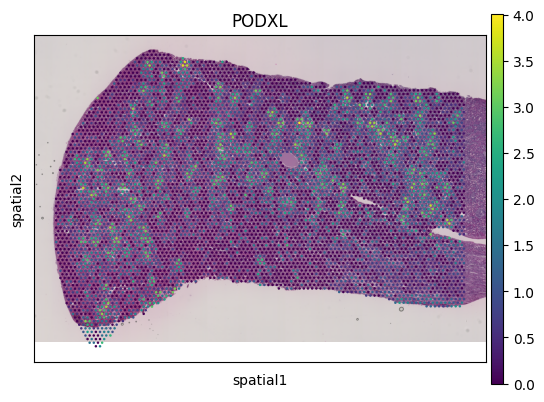

In [11]:
sc.pl.spatial(slide, color = 'PODXL')

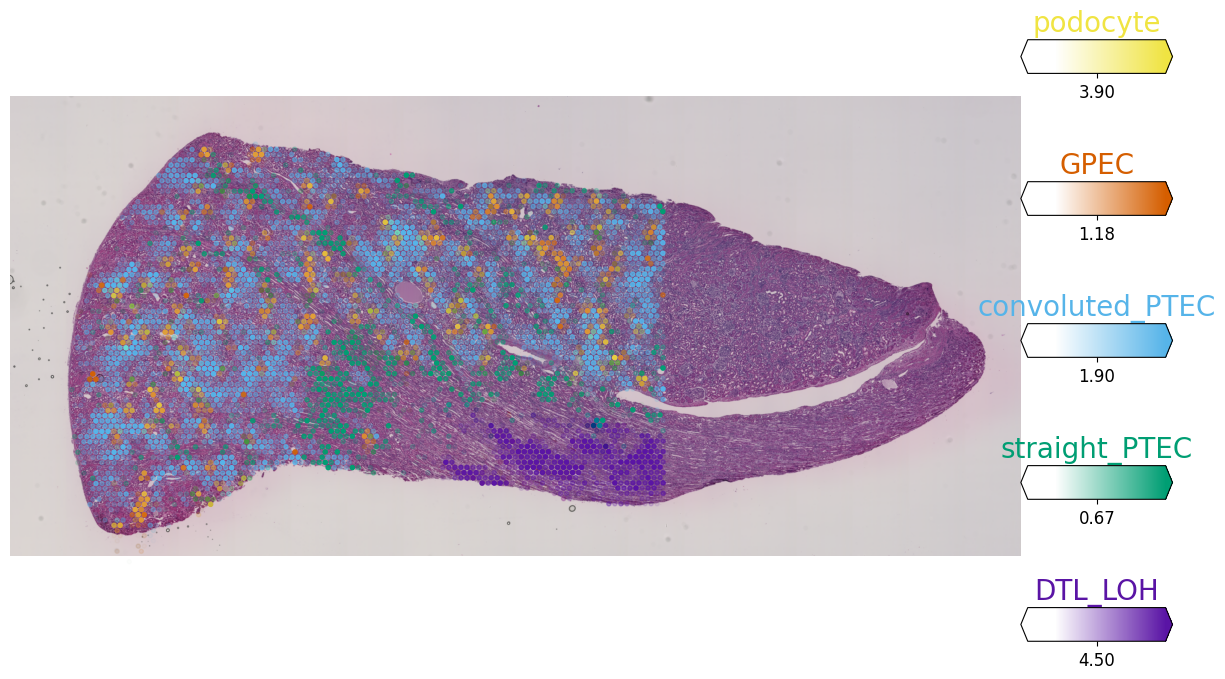

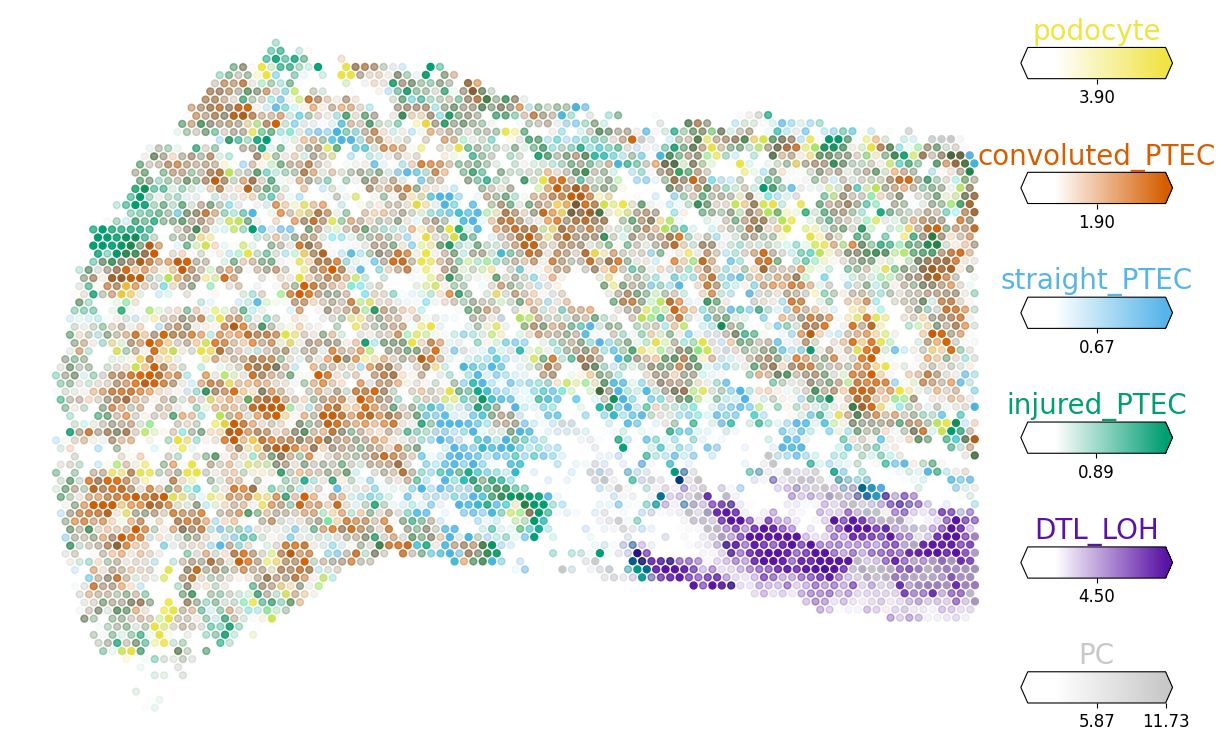

In [12]:
from cell2location.plt import plot_spatial
to_plot = ['podocyte', 'GPEC', 'convoluted_PTEC', 'straight_PTEC', 'DTL_LOH']
with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
            adata=slide,
         img_key='hires',
            # labels to show on a plot
            color= to_plot, labels = to_plot,
            show_img=True,
            # 'fast' (white background) or 'dark_background'
            style='fast',
            # limit color scale adt 99.2% quantile of cell abundance
            max_color_quantile=0.992,
            # size of locations (adjust depending on figure size)
            circle_diameter=circle_diameter,
            colorbar_position='right')
fig
fig.savefig(fname = './figures/c2l_proximal_epithelium_plot.pdf')


to_plot = ['podocyte', 'convoluted_PTEC', 'straight_PTEC', 'injured_PTEC', 'DTL_LOH', 'PC']
with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
            adata=slide,
         img_key='hires',
            # labels to show on a plot
            color= to_plot, labels = to_plot,
            show_img=False,
            # 'fast' (white background) or 'dark_background'
            style='fast',
            # limit color scale adt 99.2% quantile of cell abundance
            max_color_quantile=0.992,
            # size of locations (adjust depending on figure size)
            circle_diameter=5,
            colorbar_position='right')
fig.savefig(fname = './figures/c2l_proximal_epithelium_plot_dark.pdf')


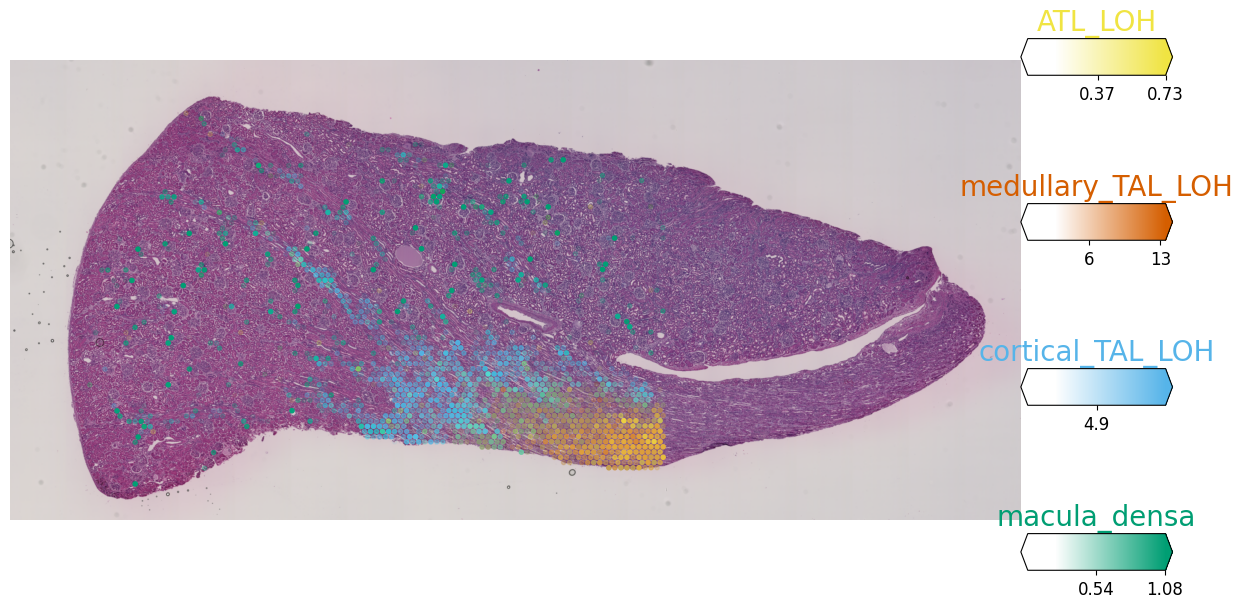

In [13]:
from cell2location.plt import plot_spatial
to_plot = [ 'ATL_LOH', 'medullary_TAL_LOH', 'cortical_TAL_LOH', 'macula_densa',]
with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
            adata=slide,
         img_key='hires',
            # labels to show on a plot
            color= to_plot, labels = to_plot,
            show_img=True,
            # 'fast' (white background) or 'dark_background'
            style='fast',
            # limit color scale adt 99.2% quantile of cell abundance
            max_color_quantile=0.992,
            # size of locations (adjust depending on figure size)
            circle_diameter=circle_diameter,
            colorbar_position='right')
fig
fig.savefig(fname = './figures/c2l_LOH_epithelium_plot.pdf')

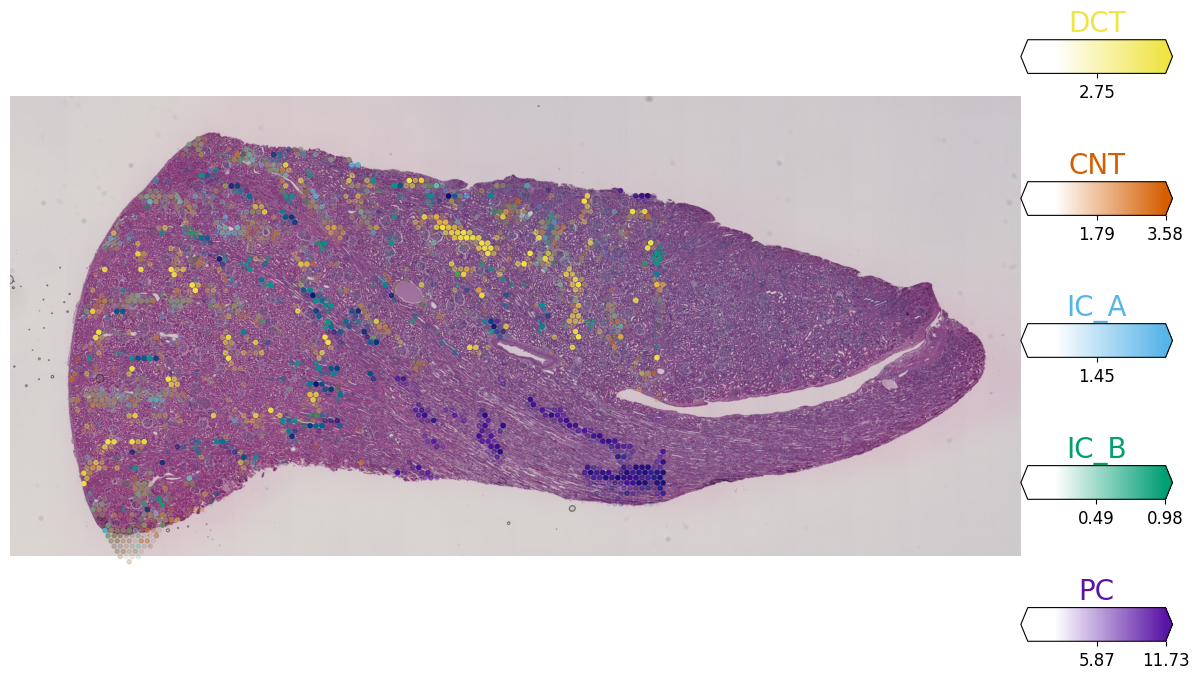

In [14]:
from cell2location.plt import plot_spatial
to_plot = ['DCT', 'CNT', 'IC_A', 'IC_B', 'PC']
with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
            adata=slide,
         img_key='hires',
            # labels to show on a plot
            color= to_plot, labels = to_plot,
            show_img=True,
            # 'fast' (white background) or 'dark_background'
            style='fast',
            # limit color scale adt 99.2% quantile of cell abundance
            max_color_quantile=0.992,
            # size of locations (adjust depending on figure size)
            circle_diameter=circle_diameter,
            colorbar_position='right')
fig
fig.savefig(fname = './figures/c2l_distal_epithelium_plot.pdf')

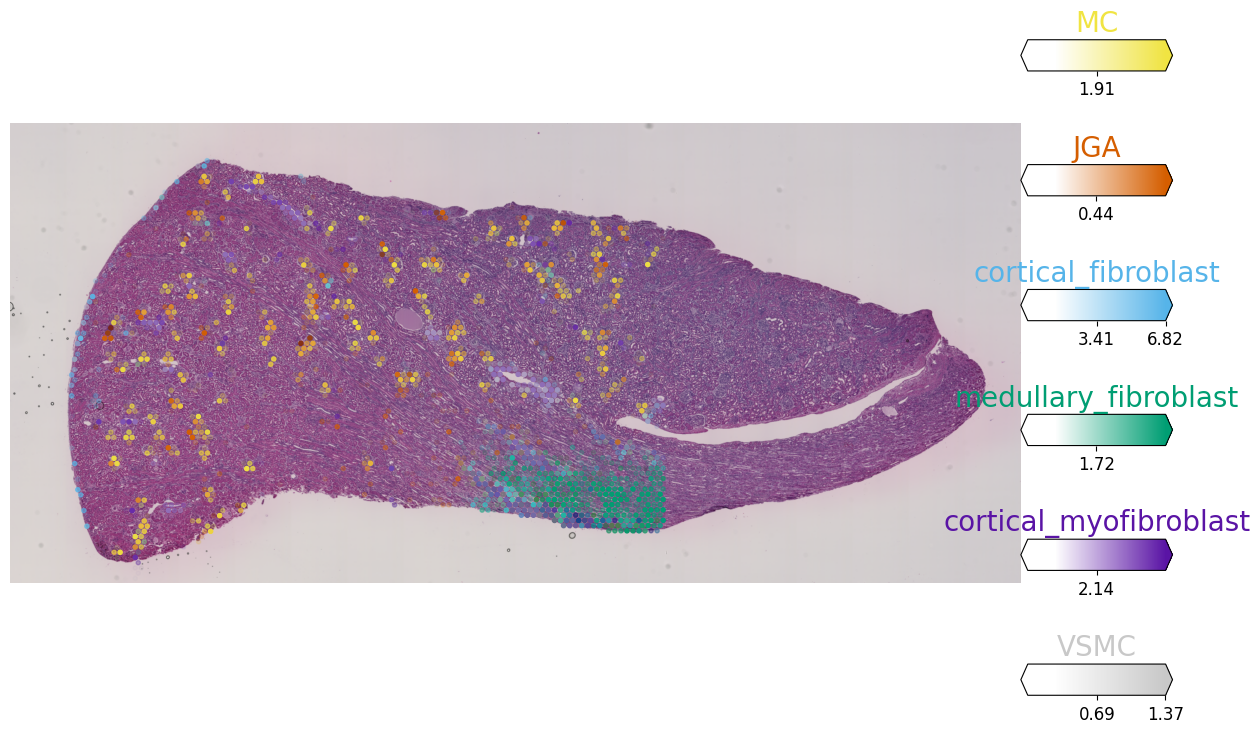

In [15]:
from cell2location.plt import plot_spatial
to_plot = ['MC', 'JGA', 'cortical_fibroblast',
       'medullary_fibroblast', 'cortical_myofibroblast', 'VSMC']
with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig =  plot_spatial(
            adata=slide,
            # labels to show on a plot
         img_key='hires',
            color= to_plot, labels = to_plot,
            show_img=True,
            # 'fast' (white background) or 'dark_background'
            style='fast',
            # limit color scale adt 99.2% quantile of cell abundance
            max_color_quantile=0.992,
            # size of locations (adjust depending on figure size)
            circle_diameter=circle_diameter,
            colorbar_position='right')
fig
fig.savefig(fname = './figures/c2l_stroma_plot.pdf')

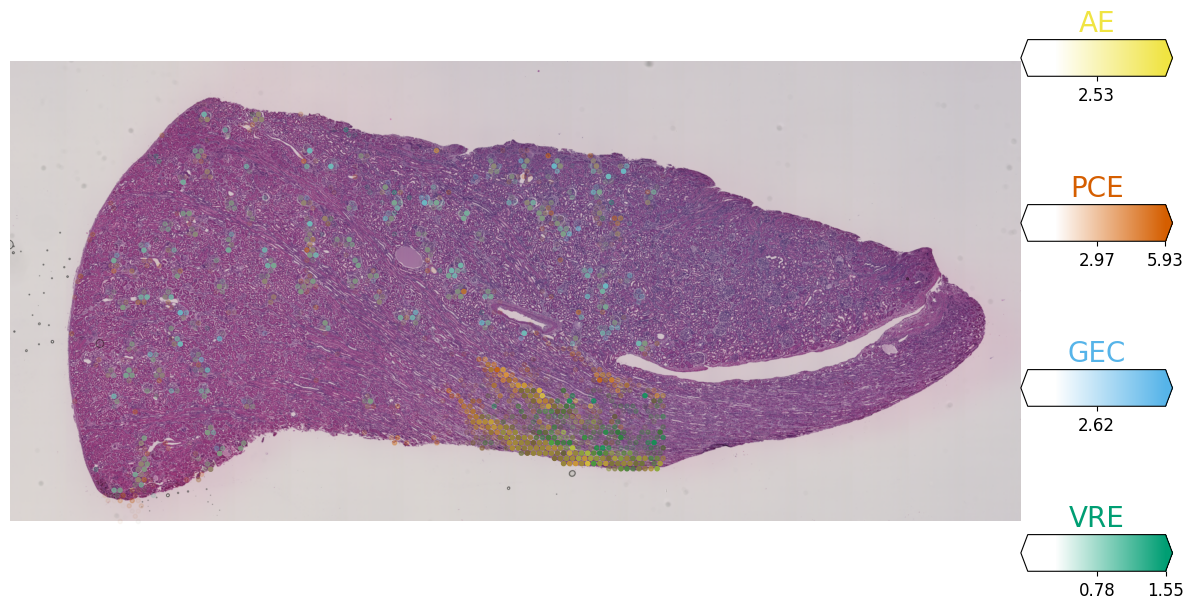

In [16]:
from cell2location.plt import plot_spatial
to_plot = ['AE', 'PCE', 'GEC', 'VRE']
with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig =  plot_spatial(
            adata=slide,
            # labels to show on a plot
         img_key='hires',
            color= to_plot, labels = to_plot,
            show_img=True,
            # 'fast' (white background) or 'dark_background'
            style='fast',
            # limit color scale adt 99.2% quantile of cell abundance
            max_color_quantile=0.992,
            # size of locations (adjust depending on figure size)
            circle_diameter=circle_diameter,
            colorbar_position='right')
fig
fig.savefig(fname = './figures/c2l_endothelium_plot.pdf')

In [17]:
#cluster the neighborhoods...

In [18]:
sc.pp.neighbors(adata, use_rep = 'q05_cell_abundance_w_sf', metric = 'cosine', n_neighbors = 30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)

/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


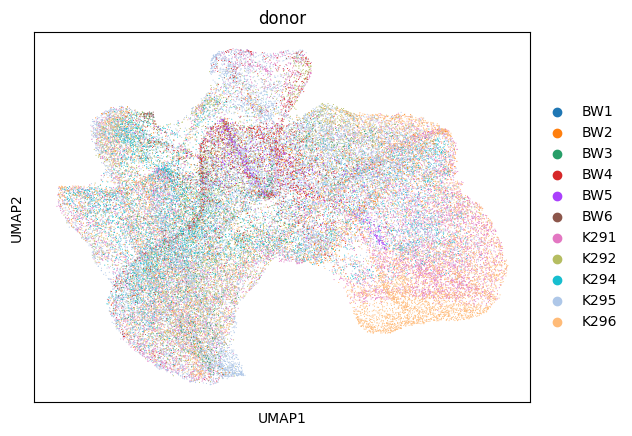

In [19]:
sc.pl.umap(adata, color = 'donor')

/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


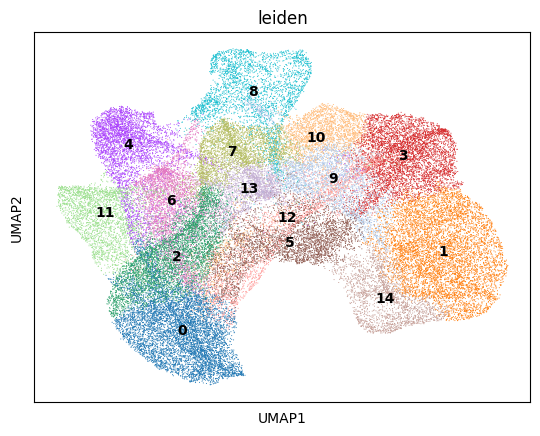

In [20]:
sc.pl.umap(adata, color = 'leiden', legend_loc = 'on data')

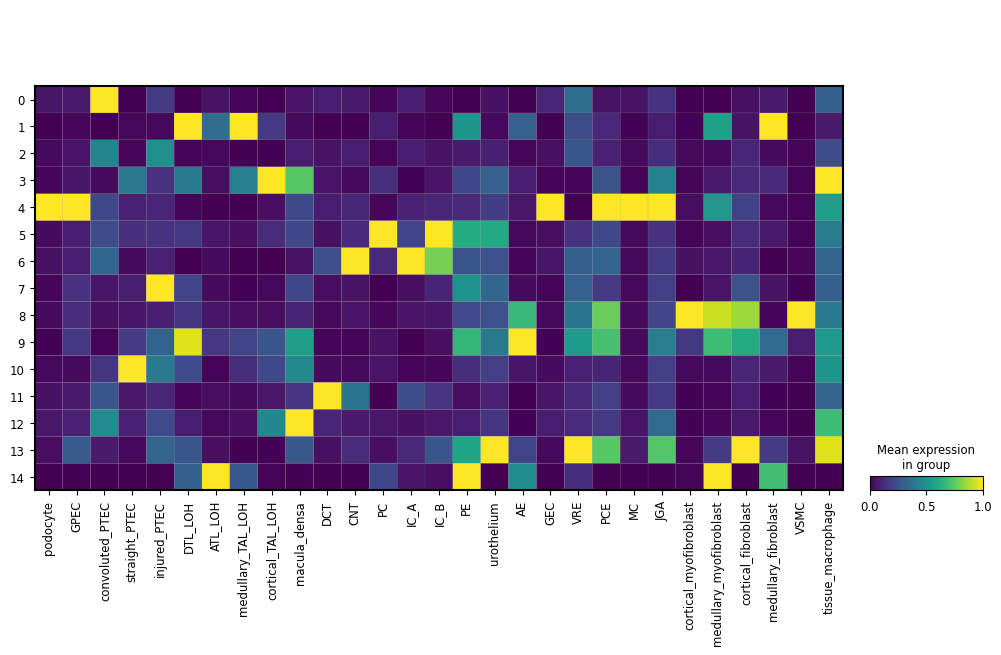

In [21]:
sc.pl.matrixplot(adata[:, ~adata.var_names.isin(adata.uns['mod']['factor_names'])], var_names = adata.uns['mod']['factor_names'], groupby ='leiden', 
                use_raw = False, standard_scale = 'var')

In [22]:
#annotate these 
niche_mapping = {'0' : 'PTEC', '1' : 'medullary_LOH', '2' : 'PTEC', '3' : 'cortical_TAL_LOH', '4' : 'glomerulus',
                 '5': 'collecting_duct', '6' : 'IC_A', '7' : 'injured_PTEC', '8' : 'perivascular', '9' : 'medullary_vascular', '10' : 'straight_PTEC', '11' : 'DCT',
                '12' : 'macula_densa', '13' : 'fibrous', '14' : 'ATL_LOH'}
adata.obs['niche'] = adata.obs['leiden'].map(niche_mapping).astype('category')

/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


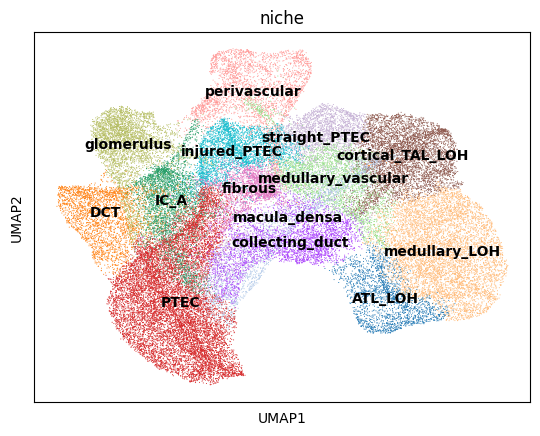

In [23]:
sc.pl.umap(adata, color = 'niche', legend_loc = 'on data')

/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


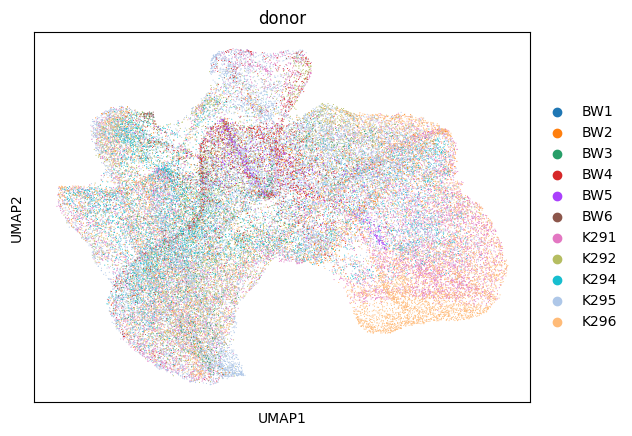

In [24]:
sc.pl.umap(adata, color = 'donor')

In [44]:
slide = select_slide(adata, np.unique(adata.obs['sample'])[6])

/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


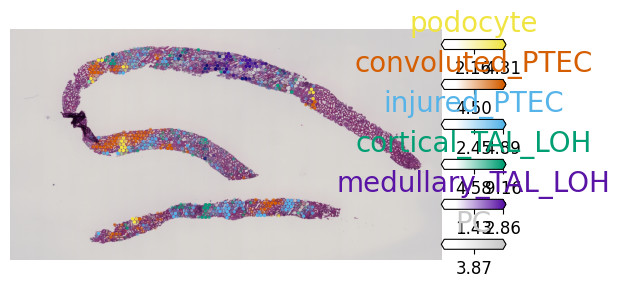

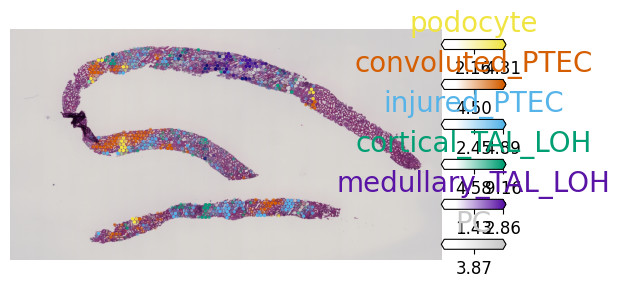

In [49]:
to_plot = ['podocyte', 'convoluted_PTEC', 'injured_PTEC', 'cortical_TAL_LOH', 'medullary_TAL_LOH', 'PC']
plot_spatial(adata=slide,img_key='hires',
                color= to_plot, labels = to_plot,show_img=True,style='fast',
                max_color_quantile=0.992,
                circle_diameter=1.5,
                colorbar_position='right')

In [ ]:
for p in list(range(6, 10, 1)):
    slide = select_slide(adata, np.unique(adata.obs['sample'])[p])
    from cell2location.plt import plot_spatial
    to_plot = ['GEC', 'convoluted_PTEC', 'injured_PTEC', 'cortical_TAL_LOH', 'ATL_LOH','PC', 'cortical_fibroblast']
    fig = plot_spatial(
                adata=slide,img_key='hires',
                color= to_plot, labels = to_plot,show_img=True,style='fast',
                max_color_quantile=0.992,
                circle_diameter=1.5,
                colorbar_position='right')
    fn= f'./figures/{p}_biopsy_plot.pdf' 
    fig.savefig(fname = fn, dpi = 1000)

/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [ ]:
sc.pl.umap(adata, color = 'CXCL8', legend_loc = 'on data')

In [ ]:
glom = adata[adata.obs['niche'].isin(['glomerulus'])]
sc.pl.dotplot(glom, groupby = 'donor', var_names = ['IL6', 'CXCL1', 'CXCL2', 'CXCL3', 'CXCL8', 'CSF3', 'CCL2', 'TGFB2', 'HBEGF', 'ICAM1', 'CD83', 'CD55',
                                                   'IRAK2', 'TRAF3', 'TRAF1', 'NFKB1', 'NFKB2'], standard_scale = 'var', cmap = 'magma')

In [ ]:
sc.pl.violin(glom, groupby = 'donor', keys = ['CXCL1'])

In [ ]:
slide = select_slide(adata, np.unique(adata.obs['sample'])[2])

In [ ]:
sc.pl.spatial(slide, color = ['niche', 'CXCL8'])

In [ ]:
slide = select_slide(adata, np.unique(adata.obs['sample'])[5])

In [ ]:
sc.pl.dotplot(slide, var_names = ['CXCL8', 'IL1B', 'TNF', 'PODXL', 'NPHS1'], groupby = 'niche', standard_scale = 'var')

In [ ]:
sc.pl.spatial(slide, color = ['niche'])

In [ ]:
sc.pl.spatial(slide, color = ['CXCL8', 'NPHS1', 'PLAT'])

In [ ]:
from cell2location.plt import plot_spatial
to_plot = ['podocyte', 'GEC', 'convoluted_PTEC', 'injured_PTEC','DTL_LOH', 'cortical_TAL_LOH', 'cortical_fibroblast']
with mpl.rc_context({'figure.figsize': (5, 5)}):
    fig =  plot_spatial(
            adata=slide,
            # labels to show on a plot
         img_key='hires',
            color= to_plot, labels = to_plot,
            show_img=False,
            # 'fast' (white background) or 'dark_background'
            style='fast',
            # limit color scale adt 99.2% quantile of cell abundance
            max_color_quantile=0.992,
            # size of locations (adjust depending on figure size)
            circle_diameter=circle_diameter,
            colorbar_position='right')
    fig.savefig(fname = './figures/c2l_endothelium_plot.pdf')

In [ ]:
slide = select_slide(adata, np.unique(adata.obs['sample'])[8])

In [ ]:
#now look at pathological specimens and compare to our healthy reference
#score everything with progeny
import decoupler as dc
progeny = dc.get_progeny(organism='human', top=500)
dc.run_wmean(mat=adata, net=progeny, verbose=True)
import liana as li
progeny_acts = li.ut.obsm_to_adata(adata, 'wmean_norm')

In [ ]:
import liana as li
progeny_acts = li.ut.obsm_to_adata(adata, 'wmean_norm')

In [ ]:
progeny_slide = select_slide(progeny_acts, np.unique(progeny_acts.obs['sample'])[2])

In [ ]:
progeny_slide.var_names

In [ ]:
sc.pl.spatial(progeny_slide, color = 'EGFR')

In [ ]:
import liana as li
comps = li.ut.obsm_to_adata(adata, 'q05_cell_abundance_w_sf')
comps_slide = select_slide(comps, np.unique(comps.obs['sample'])[2])

In [ ]:
sc.pl.spatial(comps_slide, color = 'q05cell_abundance_w_sf_IC_A')

In [ ]:
#score regulons from multiome data
regulons = pd.read_csv('./data/GRN/pando_tf_weights.csv', index_col = 0)
import decoupler as dc
dc.run_wmean(
    mat=slide,
    net=regulons,
    source='tf',
    target='target',
    weight='estimate',
    verbose=True
)
tf_acts = dc.get_acts(slide, obsm_key='wmean_norm')
tf_acts.var['cv'] =  tf_acts.X.std(axis=0) / tf_acts.X.mean(axis=0)
top_tfs = tf_acts.var.sort_values('cv', ascending=False, key=abs).head(50).index
top_tfs

In [ ]:
sc.pl.spatial(tf_acts, color=['WT1', 'EBF2', 'FOXI1'])

In [ ]:
sc.pl.spatial(slide)

In [ ]:
import liana as li
comps = li.ut.obsm_to_adata(slide, 'q05_cell_abundance_w_sf')

In [ ]:
comps

In [ ]:
#make an mdata
import liana as li
import muon as mu
mdata = mu.MuData({"celltypes": comps, "tfs": tf_acts})

In [ ]:
mdata.obs = pd.concat([slide.obs,
                       pd.DataFrame(slide.obsm["spatial"], columns=["imagerow", "imagecol"], index=slide.obs_names),
                      ], axis=1)

In [ ]:
n_inducing = 1000
mu.tl.mofa(mdata, n_factors=15,
           smooth_covariate=["imagerow", "imagecol"],
           smooth_kwargs={
               "sparseGP": True, "frac_inducing": n_inducing/mdata.n_obs,
               "start_opt": 10, "opt_freq": 10,
           },
                      outfile="data/trained/spatial/MEFISTO_cytassist_visium/mefisto_ST.hdf5",
           use_float32=True, seed=2021,
           quiet=False)

In [ ]:
import mofax

In [ ]:
m = mofax.mofa_model("data/trained/spatial/MEFISTO_cytassist_visium/mefisto_ST.hdf5")

In [ ]:
mofax.plot_factors_correlation(m);


In [ ]:
for i in range(4):
    slide.obs[f"Factor{i+1}"] = mdata.obsm["X_mofa"][:,i]

In [ ]:
sc.pl.spatial(slide, img_key="hires", color=[f"Factor{i+1}" for i in range(4)])

In [ ]:
mofax.plot_smoothness(m)

In [ ]:
top_features_f4 = m.get_top_features(factors="Factor1", n_features=3)


In [ ]:
mdata.obsm = slide.obsm

In [ ]:
mdata.uns['spatial'] = slide.uns['spatial']

In [ ]:
top_features_f4

In [ ]:
sc.pl.spatial(tf_acts, img_key="hires", color=top_features_f4[0:3])

In [ ]:
ent = entry_point()
ent.set_data_options(use_float32=True)

In [ ]:
n_inducing = 1000
ent.set_covariates(data = [slide.obsm["spatial"]], covariates_names=["imagerow", "imagecol"])
ent.set_smooth_options(sparseGP=True, frac_inducing=n_inducing/slide.n_obs,
                       start_opt=10, opt_freq=10)

In [ ]:
slide.obsm["spatial"]

In [ ]:
healthy_adata = adata[adata.obs['donor'].isin(['K291','K292', 'K294', 'K295', 'K296'])]

In [ ]:
#run misty on each sample individually.
for smp in np.unique(healthy_adata.obs['sample']):
    slide = select_slide(adata, smp)
    comps = li.ut.obsm_to_adata(slide, 'q05_cell_abundance_w_sf')
    regulons = pd.read_csv('./data/GRN/pando_tf_weights.csv', index_col = 0)
    import decoupler as dc
    dc.run_wmean(
    mat=slide,
    net=regulons,
    source='tf',
    target='target',
    weight='estimate',
    verbose=True)
    tf_acts = dc.get_acts(slide, obsm_key='wmean_norm')
    misty = genericMistyData(intra=tf_acts, extra=comps, cutoff=0.05, bandwidth=200, coord_type='generic', n_rings=1)
    misty(verbose = True)
    #save this misty object
    misty.write_h5mu("/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/spatial/FFPE_visium/" + smp + "_" + "misty_object.h5mu")

In [ ]:
smp = np.unique(healthy_adata.obs['sample'])[1]
"/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/spatial/FFPE_visium/" + smp + "_" + "misty_object.h5mu"

In [ ]:
import liana as li
from liana.method import MistyData, genericMistyData, lrMistyData

comps = li.ut.obsm_to_adata(healthy_adata, 'q05_cell_abundance_w_sf')

In [ ]:
misty = genericMistyData(intra=comps, extra=comps, cutoff=0.05, bandwidth=200, coord_type='generic', n_rings=1)

In [ ]:
misty(verbose = True)

In [ ]:
#save this misty object
misty.write_h5mu("/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/spatial/FFPE_visium/misty_object.h5mu")

In [ ]:
from cell2location.plt import plot_spatial
to_plot = ['VRE', 'GEC']
plot_spatial(
            adata=slide,
            # labels to show on a plot
         img_key='hires',
            color=to_plot, labels = to_plot,
            show_img=True,
            # 'fast' (white background) or 'dark_background'
            style='fast',
            # limit color scale adt 99.2% quantile of cell abundance
            max_color_quantile=0.992,
            # size of locations (adjust depending on figure size)
            circle_diameter=3,
            colorbar_position='right')

In [ ]:
slide = select_slide()

In [ ]:
import liana as li

In [ ]:
import squidpy as sq

In [ ]:
sq.gr.spatial_neighbors(slide)

In [ ]:
li.mt.lr_bivar(slide,
               function_name='cosine', # Name of the function
               n_perms=100, # Number of permutations to calculate a p-value
               mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
               add_categories=True, # Whether to add local categories to the results
               expr_prop=0.1, # Minimum expr. proportion for ligands/receptors and their subunits
               use_raw=False,
               verbose=True
               )

In [ ]:
lrdata

In [ ]:
lrdata = slide.obsm['local_scores']

In [ ]:
global_morans, _ = li.mt.lr_bivar(slide, function_name="morans", inplace=False, use_raw=False)

In [ ]:
lrdata.uns['global_res'].sort_values("global_sd", ascending=False).head(30)

In [ ]:
lrdata.uns['global_res'][lrdata.uns['global_res'].ligand.isin(['TNF'])]

In [ ]:
sc.pl.spatial(lrdata, color=['CSF1^SIRPA'], size=1, vmax=1)

In [ ]:
slide = select_slide(adata, np.unique(adata.obs['sample'])[7])

In [ ]:
sc.pl.spatial(slide)

In [ ]:
import decoupler as dc
dc.run_wmean(
    mat=slide,
    net=progeny,
     source='source',
    target='target',
    weight='weight',
    verbose=True
)
acts_progeny = dc.get_acts(slide, 'wmean_norm')

In [ ]:
acts_progeny.var_names.values

In [ ]:
sc.pl.spatial(acts_progeny, color=['TNFa', 'NFkB'])

In [ ]:
sc.pl.spatial(slide, color=['CXCL8', 'PODXL'])

In [ ]:
sq.gr.spatial_neighbors(slide)
li.mt.lr_bivar(slide,
               function_name='cosine', # Name of the function
               n_perms=100, # Number of permutations to calculate a p-value
               mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
               add_categories=True, # Whether to add local categories to the results
               expr_prop=0.1, # Minimum expr. proportion for ligands/receptors and their subunits
               use_raw=False,
               verbose=True
               )

In [ ]:
lrdata = slide.obsm['local_scores']

In [ ]:
global_morans, _ = li.mt.lr_bivar(slide, function_name="morans", inplace=False, use_raw=False)

In [ ]:
lrdata.uns['global_res'].sort_values("global_sd", ascending=False).head(20)

In [ ]:
sc.pl.spatial(lrdata, color=['PDGFC^PDGFRA'], size=1, vmax=1)

In [ ]:
from cell2location.plt import plot_spatial
to_plot = ['convoluted_PTEC', 'injured_PTEC', 'podocyte']
plot_spatial(
            adata=slide,
            # labels to show on a plot
         img_key='hires',
            color=to_plot, labels = to_plot,
            show_img=True,
            # 'fast' (white background) or 'dark_background'
            style='fast',
            # limit color scale adt 99.2% quantile of cell abundance
            max_color_quantile=0.992,
            # size of locations (adjust depending on figure size)
            circle_diameter=3,
            colorbar_position='right')

In [ ]:
sc.pl.spatial(slide, color = 'CXCL8')

In [ ]:
li.multi.nmf(lrdata, n_components=None, inplace=True, random_state=0, max_iter=200, verbose=True)

In [ ]:
# Extract the variable loadings
lr_loadings = li.ut.get_variable_loadings(lrdata, varm_key='NMF_H').set_index('index')
# Extract the factor scores
factor_scores = li.ut.get_factor_scores(lrdata, obsm_key='NMF_W')


In [ ]:
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response')
adata = sc.read_h5ad('./data/trained/spatial/stLVM_cytassist_visium/adata.h5ad')

In [ ]:
slide = select_slide(adata, np.unique(adata.obs['sample'])[6])

In [ ]:
to_plot = ['stLVM_AE', 'stLVM_GEC','stLVM_VRE', 'stLVM_PCE']
from cell2location.plt import plot_spatial
plot_spatial(
        adata=slide,
        # labels to show on a plot
        color= to_plot, labels = to_plot,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale adt 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=1,
        colorbar_position='right')

In [ ]:
#donor info is 
donor_mapping = {'BW1' : 'PQ21-02226',
'BW2' :   'PQ21-03954',
'BW3'   :  'PQ22-05292',
'BW4' :'PS18-36031',
'BW5' :'PS22-20580',
'BW6':  'PQ20-06456',
}
adata.obs['case_id'] = adata.obs['donor'].map(donor_mapping).astype('category')

In [ ]:
#score the spots for the GEC response geneset 
geneset = pd.read_csv("./data/da_results/perfusion/response_signatures/GEC_response_geneset.csv", index_col = 0)
sc.tl.score_genes(adata, gene_list = geneset.X)

In [ ]:
#slide 8 is good for pathology

In [ ]:
slide = select_slide(adata, np.unique(adata.obs['sample'])[8])
#subset to BW3 - lupus nephritis
slide = slide[slide.obs['donor'] == 'BW3']

In [ ]:
geneset

In [ ]:
#score the spots for the GEC response geneset 
geneset = pd.read_csv("./data/da_results/perfusion/response_signatures/GEC_response_geneset.csv", index_col = 0)
sc.tl.score_genes(slide, gene_list = geneset.X)

In [ ]:
from cell2location.plt import plot_spatial
to_plot = ['stLVM_cortical_fibroblast', 'stLVM_medullary_fibroblast', 'stLVM_MC', 'stLVM_GEC'
          ]
with mpl.rc_context({'figure.figsize': (10,5)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color= to_plot, labels = to_plot,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale adt 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=2,
        colorbar_position='right')

In [ ]:
sc.pl.spatial(slide, color = ['CXCL8', 'score', 'stLVM_GEC'])

In [ ]:
sc.pl.spatial(slide, color = ['stLVM_podocyte', 'score', 'stLVM_tissue_macrophage', 'stLVM_'])

In [ ]:
from cell2location.plt import plot_spatial
to_plot = ['stLVM_cortical_fibroblast', 'stLVM_medullary_fibroblast', 'stLVM_VSMC', 'stLVM_cortical_myofibroblast',
          'stLVM_medullary_myofibroblast', 'stLVM_medullary_TAL_LOH', 'stLVM_MC']
with mpl.rc_context({'figure.figsize': (10, 10)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color= to_plot, labels = to_plot,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale adt 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=2,
        colorbar_position='right')

In [ ]:
from cell2location.plt import plot_spatial
to_plot = ['stLVM_cortical_fibroblast', 'stLVM_medullary_fibroblast', 'stLVM_VSMC', 'stLVM_cortical_myofibroblast',
          'stLVM_medullary_myofibroblast', 'stLVM_medullary_TAL_LOH', 'stLVM_MC']
with mpl.rc_context({'figure.figsize': (10, 10)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color= to_plot, labels = to_plot,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale adt 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=2,
        colorbar_position='right')

In [ ]:
from cell2location.plt import plot_spatial
to_plot = ['stLVM_medullary_TAL_LOH', 'stLVM_podocyte', 'stLVM_injured_PTEC', 'stLVM_convoluted_PTEC']
with mpl.rc_context({'figure.figsize': (10, 10)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color= to_plot, labels = to_plot,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale adt 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=3,
        colorbar_position='right')

In [ ]:
sc.pp.neighbors(adata, use_rep = 'proportions')
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color = ['donor', 'HIF1A','AHR', 'SOX5' )

In [ ]:
sc.tl.leiden(adata, resolution = 0.5)

In [ ]:
sc.pl.umap(adata, color = 'leiden', legend_loc = 'on data')

In [ ]:
sc.pl.umap(adata, color = ['stLVM_PE', 'stLVM_medullary_fibroblast', 'CXCL8', 'stLVM_podocyte', 'stLVM_GEC', 'stLVM_PCE'])

In [ ]:
sc.pl.dotplot(adata, groupby= 'donor', var_names =  ['COL1A1', 'COL4A1', 'COL18A1'],
             standard_scale = 'var')

In [ ]:
pd.crosstab(adata.obs['sample'], adata.obs['donor'])

In [ ]:
slide = select_slide(adata, np.unique(adata.obs['sample'])[5])

In [ ]:
sc.pl.spatial(slide, color = ['leiden', 'stLVM_cortical_fibroblast'], cmap = 'magma')

In [ ]:
#get all cluster 5 from healthy and disease and compare
cl5 = adata[adata.obs['leiden'].isin(['5'])]
donor_map = {"BW2": "MPGN", 
            "BW3_BW5" : "MPGN",
            "BW4" : "MPGN", 
            "BW6_BW1":  "MPGN",
            "K291" : 'healthy',
            "K292" : 'healthy',
            "K294" : "healthy",
            "K296" : 'healthy'}
cl5.obs['pathology'] = cl5.obs['donor'].map(donor_map).astype('category')

In [ ]:
cl5.uns['log1p']["base"] = None
sc.tl.rank_genes_groups(cl5, groupby = 'pathology', use_raw = True)

In [ ]:
sc.pl.rank_genes_groups(cl5)

In [ ]:
sc.pl.spatial(slide, color = ['COL18A1', 'COL1A1'], cmap = 'magma')

In [ ]:
#read in the genesets
response_signatures = pd.read_csv("./data/da_results/perfusion/response_signatures/GEC_response_geneset.csv", index_col = 0)

In [ ]:
gec_signature = np.array(response_signatures.X)

In [ ]:
sc.tl.score_genes(adata, gene_list = gec_signature)

In [ ]:
sc.pl.violin(adata, groupby = 'donor', keys = 'score')

In [ ]:
slide = select_slide(adata, np.unique(adata.obs['sample'])[5])

In [ ]:
sc.pl.spatial(slide, color = ['score', 'stLVM_GEC', 'stLVM_PCE'], cmap = 'magma')

In [ ]:
from cell2location.plt import plot_spatial
to_plot = ['stLVM_podocyte','stLVM_convoluted_PTEC', 'stLVM_cortical_TAL_LOH', 'stLVM_medullary_TAL_LOH', 'stLVM_DCT']
with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color= to_plot, labels = to_plot,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale adt 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=2,
        colorbar_position='right')

In [ ]:
from cell2location.plt import plot_spatial
to_plot = ['stLVM_podocyte', 'stLVM_GEC', 'stLVM_MC', 'stLVM_convoluted_PTEC']
with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color= to_plot, labels = to_plot,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=2,
        colorbar_position='right')

In [ ]:
from cell2location.plt import plot_spatial
to_plot = ['stLVM_cortical_fibroblast', 'stLVM_medullary_fibroblast', 'stLVM_VSMC', 'stLVM_cortical_myofibroblast',
           'stLVM_medullary_myofibroblast', 'stLVM_MC', 'stLVM_JGA']
with mpl.rc_context({'figure.figsize': (30, 30)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color= to_plot, labels = to_plot,
        show_img=True,img_key ='hires',
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=4,
        colorbar_position='right')
#fig.savefig('./figures/stroma.pdf')

In [ ]:
sc.pl.spatial(slide, color = to_plot, cmap = 'magma', save = 'stromacelltypes.pdf')

In [ ]:
from cell2location.plt import plot_spatial
to_plot = ['stLVM_podocyte', 'stLVM_convoluted_PTEC', 
           'stLVM_medullary_TAL_LOH', 'stLVM_cortical_TAL_LOH',  'stLVM_DTL_LOH', 'stLVM_ATL_LOH']
with mpl.rc_context({'figure.figsize': (20,20)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color= to_plot, labels = to_plot,
        show_img=True,img_key ='hires',
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=4,
        colorbar_position='right')


In [ ]:
from cell2location.plt import plot_spatial
to_plot = ['stLVM_podocyte', 'stLVM_convoluted_PTEC', 
           'stLVM_medullary_TAL_LOH', 'stLVM_cortical_TAL_LOH',  'stLVM_DTL_LOH', 'stLVM_ATL_LOH']
with mpl.rc_context({'figure.figsize': (30, 30)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color= to_plot, labels = to_plot,
        show_img=True,img_key ='hires',
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=4,
        colorbar_position='right')
fig.savefig('./figures/epithelium.pdf')

In [ ]:
from cell2location.plt import plot_spatial
to_plot = ['stLVM_convoluted_PTEC', 'stLVM_straight_PTEC', 'stLVM_injured_PTEC']
with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color= to_plot, labels = to_plot,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=2,
        colorbar_position='right')

In [ ]:
from cell2location.plt import plot_spatial
to_plot = ['stLVM_AE', 'stLVM_GEC', 'stLVM_PCE', 'stLVM_VRE']
with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color= to_plot, labels = to_plot,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=2,
        colorbar_position='right')

In [ ]:
from cell2location.plt import plot_spatial
to_plot = ['stLVM_GPEC', 'stLVM_macula_densa', 'stLVM_DCT', 'stLVM_CNT', 'stLVM_IC_A', 'stLVM_IC_B', 'stLVM_PC']
with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color= to_plot, labels = to_plot,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=2,
        colorbar_position='right')

In [ ]:
import seaborn as sns
sns.clustermap(slide.obsm['proportions'].corr(method = 'spearman'), yticklabels=True, xticklabels=True, vmin = -1, vmax = 1)

In [ ]:
#can we plot MIRA topics on these data? 

In [ ]:
import anndata as ad

In [ ]:
#for each sample do a clustering solution based on the proportions
cluster_list = []
sl_prop = ad.AnnData(X = adata.obsm['proportions'], obs = adata.obs)
for sl in np.unique(adata.obs['sample']):
    print(sl)
    sl_prop_sl = sl_prop[sl_prop.obs['sample'].isin([sl])]
    sc.pp.neighbors(sl_prop_sl)
    sc.tl.leiden(sl_prop_sl)
    cluster_list.append(sl + "_" +np.array( sl_prop_sl.obs['leiden']))
    del sl_prop_sl

In [ ]:
adata.obs['raw_clusters'] = np.concatenate(cluster_list)

In [ ]:
sc.pp.filter_genes(adata, min_cells = 20)

In [ ]:
#subset this to variable genes
sc.pp.highly_variable_genes(adata, flavor = 'seurat_v3', layer = 'counts', n_top_genes = 3000, subset = True)

In [ ]:
import hotspot
#make an hotspot object
hsobj = hotspot.Hotspot(
    adata,
    layer_key="counts",
    model='bernoulli',
    latent_obsm_key="spatial",
    umi_counts_obs_key = "total_counts"
)

In [ ]:
#helper function to do weights
from math import ceil
def compute_weights(distances, neighborhood_factor=3):
    """
    Computes weights on the nearest neighbors based on a
    gaussian kernel and their distances

    Kernel width is set to the num_neighbors / neighborhood_factor's distance

    distances:  cells x neighbors ndarray
    neighborhood_factor: float

    returns weights:  cells x neighbors ndarray

    """

    radius_ii = ceil(distances.shape[1] / neighborhood_factor)

    sigma = distances[:, [radius_ii-1]]
    sigma[sigma == 0] = 1

    weights = np.exp(-1 * distances**2 / sigma**2)

    wnorm = weights.sum(axis=1, keepdims=True)
    wnorm[wnorm == 0] = 1.0
    weights = weights / wnorm

    return weights

#now build a seperate knn graph for each library from the spatial data.
n_neighbors= 5
neighborhood_factor = 3
#list through the samples
neighbors_list = []
weights_list = []
for smp in np.unique(adata.obs['sample']):
    print(smp)
    slide = select_slide(adata, smp)
    dat = slide.obsm['spatial']
    from pynndescent import NNDescent
    index = NNDescent(dat, n_neighbors=n_neighbors + 1)
    ind, dist = index.neighbor_graph
    ind, dist = ind[:, 1:], dist[:, 1:]
    weights = compute_weights(dist, neighborhood_factor=neighborhood_factor)
    ind = pd.DataFrame(ind, index=slide.obs_names)
    neighbors = ind
    n_index = neighbors.index
    n_list = []
    for i in n_index:
        n_list.append(pd.DataFrame(n_index[neighbors.loc[i].to_list()]).T)
    neighbors = pd.concat(n_list)
    neighbors.index = n_index    #instead of using neighbors numerically we convert them to cell names
    neighbors_list.append(neighbors)
    weights = pd.DataFrame(weights, index=neighbors.index,
                           columns=neighbors.columns)
    weights_list.append(weights)
    
neighbors = pd.concat(neighbors_list) 
weights = pd.concat(weights_list)

#convert neighbors to numeric values
index_values = np.array(neighbors.index)
index_mapping = {index_val: i for i, index_val in enumerate(index_values)}
neighbors_list = []
for column in neighbors:
    array_values = neighbors[column].values
    # Create a list of numeric values corresponding to the array elements using the index mapping
    numeric_output = [index_mapping[array_val] for array_val in array_values]
    neighbors_list.append(np.array(numeric_output))
neighbors = pd.DataFrame(neighbors_list).T
neighbors.index = index_values

In [ ]:
#add these neighbors and weights to the hotspot object.
hsobj.neighbors = neighbors
hsobj.weights = weights

In [ ]:
#hsobj.create_knn_graph(weighted_graph=False, n_neighbors=20)

In [ ]:
hs_results = hsobj.compute_autocorrelations()

In [ ]:
hs_genes = hs_results.loc[hs_results.FDR < 0.05].index # Select genes
local_correlations = hsobj.compute_local_correlations(hs_genes, jobs=6) # jobs for parallelization

In [ ]:
modules = hsobj.create_modules(
    min_gene_threshold=50, core_only=True, fdr_threshold=0.05
)

In [ ]:
module_scores = hsobj.calculate_module_scores()

In [ ]:
#add the module scores to obs 
module_cols = []
for c in module_scores.columns:
    key = f"hs_module_{c}"
    adata.obs[key] = module_scores[c]
    module_cols.append(key)

In [ ]:
#add the modules scores as an obsm
adata.obsm['X_hotspot'] = module_scores.to_numpy()

In [ ]:
sl = np.unique(adata.obs['sample'])[5]
slide = select_slide(adata, sl)

In [ ]:
import hotspot
#make an hotspot object
hsobj = hotspot.Hotspot(
    slide,
    layer_key="counts",
    model='bernoulli',
    latent_obsm_key="spatial",
    umi_counts_obs_key = "total_counts"
)

In [ ]:
hsobj.create_knn_graph(weighted_graph=False, n_neighbors=20)

In [ ]:
hs_results = hsobj.compute_autocorrelations()

In [ ]:
hs_genes = hs_results.loc[hs_results.FDR < 0.05].index # Select genes
local_correlations = hsobj.compute_local_correlations(hs_genes, jobs=6) # jobs for parallelization

In [ ]:
modules = hsobj.create_modules(
    min_gene_threshold=50, core_only=True, fdr_threshold=0.05
)

In [ ]:
module_scores = hsobj.calculate_module_scores()

In [ ]:
module_cols = []
for c in module_scores.columns:
    key = f"hs_module_{c}"
    slide.obs[key] = module_scores[c]
    module_cols.append(key)

In [ ]:
#add the modules scores as an obsm
slide.obsm['X_hotspot'] = module_scores.to_numpy()

In [ ]:
#for each sample do a clustering solution based on the proportions
cluster_list = []
sl_prop = ad.AnnData(X = adata.obsm['proportions'], obs = adata.obs)
for sl in np.unique(adata.obs['sample']):
    print(sl)
    sl_prop_sl = sl_prop[sl_prop.obs['sample'].isin([sl])]
    sc.pp.neighbors(sl_prop_sl)
    sc.tl.leiden(sl_prop_sl)
    cluster_list.append(sl + "_" +np.array( sl_prop_sl.obs['leiden']))
    del sl_prop_sl

In [ ]:
sc.pl.spatial(slide, color = ['stLVM_podocyte', 'stLVM_GEC', 'stLVM_GPEC', 'stLVM_DTL_LOH',
                             'stLVM_B_cell', 'stLVM_CD8_T_cell', 
                             'stLVM_MC', 'CCL28'], cmap  = 'cividis')

In [ ]:
hsdf = pd.DataFrame(adata_scvi.obsm['X_scVI'])
hsdf['cluster'] = pd.Categorical(np.array(adata.obs['raw_clusters']))

In [ ]:
hsdf = hsdf.groupby('cluster').mean()

In [ ]:
cl_adata = ad.AnnData(X = hsdf)

In [ ]:
sc.pp.neighbors(cl_adata)

In [ ]:
sc.tl.umap(cl_adata)

In [ ]:
sc.tl.leiden(cl_adata, resolution = 1.5)

In [ ]:
sc.pl.umap(cl_adata, color = 'leiden', legend_loc = 'on data')

In [ ]:
mapping_dict = cl_adata.obs['leiden'].to_dict()
adata.obs['cluster'] = adata.obs['raw_clusters'].map(mapping_dict).astype('category')

In [ ]:
sl = np.unique(adata.obs['sample'])[5]
slide = select_slide(adata, sl)

In [ ]:
sc.pl.spatial(slide, color = 'cluster', groups = '4')

In [ ]:
proportion_cols = slide.obs.loc[:, slide.obs.columns.str.startswith('stLVM')].columns

In [ ]:
#get the average module scores for each raw clusters
sc.pl.matrixplot(slide, groupby = 'cluster', var_names = proportion_cols, dendrogram = True,
                vmax= 0.3)

In [ ]:
import destvi_utils as du
from scvi.model import CondSCVI, DestVI
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response')
sc_model = CondSCVI.load('./data/trained/spatial/condVI_cytassist_visium/')
st_model = DestVI.load('./data/trained/spatial/stLVM_cytassist_visium/')

In [ ]:
du.explore_gamma_space(
    st_model, sc_model, ct_list=['classical_monocyte', 'B_cell']
)

In [ ]:
# nearest neighbor graph
import squidpy as sq
sc.pp.neighbors(adata, use_rep = "X_hotspot")
nn_graph_genes = adata.obsp["connectivities"]
# spatial proximity graph
sq.gr.spatial_neighbors(adata, library_key = 'sample')
nn_graph_space = adata.obsp["spatial_connectivities"]

In [ ]:
alpha = 0.2
joint_graph = (1 - alpha) * nn_graph_genes + alpha * nn_graph_space
sc.tl.leiden(adata, adjacency=joint_graph, key_added="squidpy_domains")

In [ ]:
sc.tl.leiden(adata, adjacency=joint_graph, key_added="squidpy_domains", resolution = 0.5)

In [ ]:
adata.obsp["connectivities"] = joint_graph

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color = 'squidpy_domains', legend_loc = 'on data')

In [ ]:
sl = np.unique(adata.obs['sample'])[7]
slide = select_slide(adata, sl)
sc.pl.spatial(slide, color = 'squidpy_domains',groups = '12')

In [ ]:
sc.pl.spatial(slide, color = 'squidpy_domains',groups = '12')

In [ ]:
stlvm_plot = ['stLVM_podocyte', 'stLVM_GEC', 'stLVM_PTEC', 'stLVM_DTL_LOH', 'stLVM_TAL_LOH', 
                         'stLVM_AE', 'stLVM_PCE', 'stLVM_Mfib', 'stLVM_NK2', 'stLVM_NK1',
                         'stLVM_classical_monocyte']

In [ ]:
sc.pl.umap(adata, color = stlvm_plot)

In [ ]:
sc.pl.matrixplot(adata, groupby = 'squidpy_domains', 
             var_names = ['stLVM_podocyte', 'stLVM_GEC', 'stLVM_PTEC', 'stLVM_DTL_LOH', 'stLVM_TAL_LOH', 
                         'stLVM_AE', 'stLVM_PCE', 'stLVM_Mfib', 'stLVM_NK2', 'stLVM_NK1',
                         'stLVM_classical_monocyte'],
                 standard_scale = 'var'
                )

In [ ]:
#or use hotspot to get scores that vary meaningfully spatially....

In [ ]:
sc.pp.neighbors(adata, use_rep = 'trimmed_proportions', metric = 'correlation', n_neighbors = 30)

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata,color = ['stLVM_podocyte', 'stLVM_GEC', 'stLVM_PTEC', 'stLVM_Treg', 'stLVM_Treg'], cmap  = 'coolwarm')

In [ ]:
sc.pl.umap(adata,color = ['sample'])

In [ ]:
sc.tl.leiden(adata)

In [ ]:
sc.pl.umap(adata,color = ['leiden'], cmap  = 'coolwarm', legend_loc = 'on data')

In [ ]:
sc.pl.matrixplot(adata, var_names =  ['stLVM_podocyte', 'stLVM_GEC', 'stLVM_PTEC',  'stLVM_IC', 'stLVM_Treg', 'stLVM_classical_monocyte', 'stLVM_NK1'],
                groupby = 'leiden', standard_scale = 'var')

In [ ]:
sc.pl.umap(adata,color = ['stLVM_podocyte', 'stLVM_GEC', 'stLVM_PTEC', 'stLVM_Treg', 'stLVM_classical_monocyte', 'stLVM_IC'], cmap  = 'coolwarm')